In [1]:
import json
import os
import pandas as pd
import geopandas as gpd
import h3
import copy
import datetime
from datetime import date, datetime
from matplotlib import pyplot as plt
import numpy as np
import urllib.request, json 

from pandasql import sqldf, load_meat, load_births
pysqldf = lambda q: sqldf(q, globals())

# Loading Data

In [2]:
pathname = "../Data/my-take-out/Location History/Semantic Location History/"

def load_and_process_json_files(pathname):
    data = [] #A void list is defined
    all_folders = [x[0] for x in os.walk(pathname)] #Get all the folders contained within the pathname
    for folder in all_folders: #Iterate over every folders
        for filename in os.listdir(folder): #Iterate over all files
            if filename.endswith('.json'):
                with open(os.path.join(folder, filename), 'r') as file:
                    json_data = json.load(file)    #The json data is extracted
                    data.append(json_data)         #The void list is updated with the new data
    return data

data = load_and_process_json_files(pathname)

# Merging all data

In [3]:
#all folders within the pathname are iterated.
all_folders = [x[2] for x in os.walk(pathname)]   
#we iterate again to get a single list with all year_month folders.
all_folders_flat_list = [item for sublist in all_folders for item in sublist]

In [4]:
#all folders within the pathname are iterated.
all_folders = [x[2] for x in os.walk(pathname)]   
#iterating again to get a single list with all year_month folders.
all_folders_flat_list = [item for sublist in all_folders for item in sublist]

#Void lists are generated
activitySegment_list = []       #list to append all activitySegment jsons
activitySegment_month_list = [] #list to append what file is the data coming from

placeVisit_list = []            #list to append all activitySegment jsons
placeVisit_month_list = []      #list to append what file is the data coming from

# iterating again for every year_month folder
count = 0
for month_data in data:
    count+=1
    # Get the real json structure under the timelineObject
    for item in month_data["timelineObjects"]:
        # Checking if it belongs to activitySegment. If it is, the data is appended in the activity list.
        try:
            item["activitySegment"]
            activitySegment_list.append(item)
            activitySegment_month_list.append(all_folders_flat_list[count])
            
        # Otherwise data is appended in the placeVisit.
        except:
            placeVisit_list.append(item)
            placeVisit_month_list.append(all_folders_flat_list[count])
    

In [5]:
activitySegment_list

[{'activitySegment': {'startLocation': {'latitudeE7': 414059525,
    'longitudeE7': 22095653,
    'placeId': 'ChIJwRsce0ajpBIRhRAr2E6CJeE',
    'address': 'Avinguda Diagonal, 75, 08019 Barcelona, Espanya',
    'locationConfidence': 99.88234},
   'endLocation': {'latitudeE7': 414059525,
    'longitudeE7': 22095653,
    'placeId': 'ChIJwRsce0ajpBIRhRAr2E6CJeE',
    'address': 'Avinguda Diagonal, 75, 08019 Barcelona, Espanya',
    'locationConfidence': 98.61288},
   'duration': {'startTimestamp': '2013-09-01T07:21:29.431Z',
    'endTimestamp': '2013-09-01T07:34:34.298Z'},
   'distance': 2389,
   'confidence': 'LOW',
   'activities': [{'activityType': 'IN_VEHICLE', 'probability': 0.0},
    {'activityType': 'CYCLING', 'probability': 0.0},
    {'activityType': 'WALKING', 'probability': 0.0}],
   'waypointPath': {'waypoints': [{'latE7': 414061889, 'lngE7': 22089648},
     {'latE7': 414111938, 'lngE7': 22188847},
     {'latE7': 414128265, 'lngE7': 22178344},
     {'latE7': 414056701, 'lngE7': 

# Converting it to dataframes

In [6]:
placeVisit_df = pd.json_normalize(placeVisit_list)
placeVisit_df["source_file"] = placeVisit_month_list
activitySegment_df = pd.json_normalize(activitySegment_list)
activitySegment_df["source_file"] = activitySegment_month_list

In [7]:
placeVisit_df

placeVisit.location.latitudeE7  placeVisit.location.longitudeE7  \
0                        414059525.0                       22095653.0   
1                        422330100.0                       26323560.0   
2                        422328172.0                       26296710.0   
3                        422330100.0                       26323560.0   
4                        422338828.0                       26319543.0   
...                              ...                              ...   
6503                     525305726.0                      133791755.0   
6504                     525295604.0                      133840735.0   
6505                     525318835.0                      133883826.0   
6506                     525219184.0                      134132147.0   
6507                     525120350.0                      133912020.0   

      placeVisit.location.placeId  \
0     ChIJwRsce0ajpBIRhRAr2E6CJeE   
1     ChIJXZSptju4uhIR9DOtWjX9H7U   
2     ChIJVZBjJDu4uhIRVkeIG1VR7qQ   
3     ChIJXZSptju4uhIR9DOtWjX9H7U   
4     ChIJST8x4Dq4uhIRjE17wBS4a1s   
...                           ...   
6503  ChIJ3eWqqpRRqEcRjILZ3j4y0Hs   
6504  ChIJBUEJietRqEcRM-_HFj_aQig   
6505  ChIJ05q01-1RqEcRGDTqjYS5BBs   
6506  ChIJbygR2x5OqEcRbhbkZsMB_DA   
6507  ChIJj6ALgtBRqEcRb6N17kXnwrg   

                            placeVisit.location.address  \
0       Avinguda Diagonal, 75, 08019 Barcelona, Espanya   
1     Carrer Sant Joan, 12, 17853 Tortellà, Girona, ...   
2      Plaça Mercat, 21, 17853 Tortellà, Girona, España   
3     Carrer Sant Joan, 12, 17853 Tortellà, Girona, ...   
4     Carrer de França, 1, 17853 Tortellà, Girona, E...   
...                                                 ...   
6503      Invalidenstraße 43, 10115 Berlin, Deutschland   
6504      Chausseestraße 118, 10115 Berlin, Deutschland   
6505     Invalidenstraße 131, 10115 Berlin, Deutschland   
6506                          10178 Berlin, Deutschland   
6507  Charlottenstraße 60, Bezirk Mitte 10117 Berlin...   

      placeVisit.location.locationConfidence  \
0                                  98.612880   
1                                  38.099730   
2                                  40.062973   
3                                  47.195095   
4                                  18.509200   
...                                      ...   
6503                               99.998900   
6504                               50.617700   
6505                               66.165870   
6506                               95.510770   
6507                               99.999530   

     placeVisit.duration.startTimestamp placeVisit.duration.endTimestamp  \
0              2013-09-01T07:34:34.298Z         2013-09-01T07:44:34.878Z   
1              2013-09-01T09:52:27.053Z         2013-09-01T10:19:38.407Z   
2              2013-09-01T14:04:30.641Z         2013-09-01T15:39:49.341Z   
3              2013-09-01T15:55:07.937Z         2013-09-01T19:41:48.263Z   
4              2013-09-01T21:49:25.203Z         2013-09-01T22:43:28.705Z   
...                                 ...                              ...   
6503               2016-08-31T09:51:37Z         2016-08-31T11:33:34.772Z   
6504           2016-08-31T11:37:39.809Z         2016-08-31T11:54:50.155Z   
6505           2016-08-31T11:56:51.229Z         2016-08-31T13:57:04.183Z   
6506           2016-08-31T14:30:18.222Z         2016-08-31T15:12:00.933Z   
6507           2016-08-31T15:16:11.142Z         2016-08-31T15:49:41.026Z   

     placeVisit.placeConfidence  placeVisit.centerLatE7  \
0               HIGH_CONFIDENCE             414057345.0   
1                LOW_CONFIDENCE             422328000.0   
2             MEDIUM_CONFIDENCE             422327867.0   
3             MEDIUM_CONFIDENCE             422327107.0   
4                LOW_CONFIDENCE             422347123.0   
...                         ...                     ...   
6503                        NaN             525302082.0   
6504         

In [8]:
activitySegment_df

activitySegment.startLocation.latitudeE7  \
0                                  414059525.0   
1                                          NaN   
2                                          NaN   
3                                  422327107.0   
4                                  422327140.0   
...                                        ...   
7279                               525318835.0   
7280                               525219184.0   
7281                               525120350.0   
7282                               525147625.0   
7283                               524648087.0   

      activitySegment.startLocation.longitudeE7  \
0                                    22095653.0   
1                                           NaN   
2                                           NaN   
3                                    26309551.0   
4                                    26309697.0   
...                                         ...   
7279                                133883826.0   
7280                                134132147.0   
7281                                133912020.0   
7282                                134503060.0   
7283                                133868816.0   

     activitySegment.startLocation.placeId  \
0              ChIJwRsce0ajpBIRhRAr2E6CJeE   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
7279                                   NaN   
7280           ChIJbygR2x5OqEcRbhbkZsMB_DA   
7281           ChIJj6ALgtBRqEcRb6N17kXnwrg   
7282                                   NaN   
7283                                   NaN   

                  activitySegment.startLocation.address  \
0       Avinguda Diagonal, 75, 08019 Barcelona, Espanya   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
7279                                                NaN   
7280                          10178 Berlin, Deutschland   
7281  Charlottenstraße 60, Bezirk Mitte 10117 Berlin...   
7282                                                NaN   
7283                                                NaN   

      activitySegment.startLocation.locationConfidence  \
0                                             99.88234   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
...                                                ...   
7279                                               NaN   
7280                                          95.51077   
7281                                          99.99953   
7282                                               NaN   
7283                                               NaN   

      activitySegment.endLocation.latitudeE7  \
0                                414059525.0   
1                                        NaN   
2                                        NaN   
3                                422327140.0   
4                                422338828.0   
...                                      ...   
7279                             525197993.0   
7280                             525121924.0   
7281                             525148601.0   
7282                             502561525.0   
7283                             413875272.0   

      activitySegment.endLocation.longitudeE7  \
0                                  22095653.0   
1                                         NaN   
2                                         NaN   
3                                  26309697.0   
4          

In [9]:
placeVisit_df.iloc[:,0:32].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 32 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   placeVisit.location.latitudeE7                                               6507 non-null   float64
 1   placeVisit.location.longitudeE7                                              6507 non-null   float64
 2   placeVisit.location.placeId                                                  6508 non-null   object 
 3   placeVisit.location.address                                                  6417 non-null   object 
 4   placeVisit.location.locationConfidence                                       6508 non-null   float64
 5   placeVisit.duration.startTimestamp                                           6508 non-null   object 
 6   placeVisit.duration.endTimestamp        

# Summarizing our DataFrames

## Visited Places

In [10]:
# Select only the columns that add value to us. 
visited_places = placeVisit_df[["placeVisit.location.latitudeE7",
                                "placeVisit.location.longitudeE7",
                                "placeVisit.location.locationConfidence",
                                "placeVisit.duration.startTimestamp", 
                                "placeVisit.duration.endTimestamp", 
                                "placeVisit.placeConfidence",
                                "placeVisit.location.name",
                                "placeVisit.location.placeId", 
                                "placeVisit.location.address",
                                "source_file"]]


# Rename those columns names with more suitable ones.
visited_places = visited_places.rename(columns={
                               "placeVisit.location.latitudeE7":"latitude",
                               "placeVisit.location.longitudeE7":"longitude",
                               "placeVisit.location.locationConfidence":"loc_confindence",
                               "placeVisit.duration.startTimestamp":"startTimestamp", 
                               "placeVisit.duration.endTimestamp":"endTimestamp", 
                               "placeVisit.placeConfidence":"placeConfidence",
                               "placeVisit.location.name": "loc_name",
                               "placeVisit.location.placeId":"place_id", 
                               "placeVisit.location.address":"loc_address"})


visited_places["latitude"]            = visited_places.apply(lambda x: x["latitude"]/10**7,axis=1)
visited_places["longitude"]           = visited_places.apply(lambda x: x["longitude"]/10**7,axis=1)
visited_places["start_datetime"]      = visited_places.apply(lambda x: np.datetime64(x["startTimestamp"]),axis=1)
visited_places["end_datetime"]        = visited_places.apply(lambda x: np.datetime64(x["endTimestamp"]),axis=1)
visited_places["duration"]            = visited_places.apply(lambda x: (x["end_datetime"]-x["start_datetime"]).total_seconds()/(60),axis=1)
visited_places = visited_places.dropna()

/var/folders/5h/h364vcws335c872gj8pv3jvm0000gn/T/ipykernel_31264/1846569503.py:29: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  visited_places["start_datetime"]      = visited_places.apply(lambda x: np.datetime64(x["startTimestamp"]),axis=1)
/var/folders/5h/h364vcws335c872gj8pv3jvm0000gn/T/ipykernel_31264/1846569503.py:30: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  visited_places["end_datetime"]        = visited_places.apply(lambda x: np.datetime64(x["endTimestamp"]),axis=1)


In [11]:
visited_places

latitude  longitude  loc_confindence            startTimestamp  \
1     42.233010   2.632356        38.099730  2013-09-01T09:52:27.053Z   
2     42.232817   2.629671        40.062973  2013-09-01T14:04:30.641Z   
3     42.233010   2.632356        47.195095  2013-09-01T15:55:07.937Z   
4     42.233883   2.631954        18.509200  2013-09-01T21:49:25.203Z   
5     42.232817   2.629671        46.037770  2013-09-02T10:39:23.330Z   
...         ...        ...              ...                       ...   
6430  41.194867   1.637823        27.902746  2016-08-13T12:55:11.180Z   
6431  41.199889   1.643278        70.955000      2016-08-13T15:41:27Z   
6433  41.387015   2.170047        99.275566      2016-08-13T20:58:24Z   
6434  41.387015   2.170047        99.938770  2016-08-13T21:19:36.305Z   
6435  41.385446   2.163762        65.165726      2016-08-13T23:32:45Z   

                  endTimestamp    placeConfidence                loc_name  \
1     2013-09-01T10:19:38.407Z     LOW_CONFIDENCE     Hotel Alta Garrotxa   
2     2013-09-01T15:39:49.341Z  MEDIUM_CONFIDENCE  Ajuntament de Tortellà   
3     2013-09-01T19:41:48.263Z  MEDIUM_CONFIDENCE     Hotel Alta Garrotxa   
4     2013-09-01T22:43:28.705Z     LOW_CONFIDENCE   Juan Verges Verdaguer   
5     2013-09-02T11:18:30.003Z     LOW_CONFIDENCE  Ajuntament de Tortellà   
...                        ...                ...                     ...   
6430  2016-08-13T15:40:31.036Z  MEDIUM_CONFIDENCE    Camping Mar De Cunit   
6431      2016-08-13T15:47:17Z     LOW_CONFIDENCE        Camping la Rueda   
6433  2016-08-13T21:04:55.973Z    HIGH_CONFIDENCE      Plaça de Catalunya   
6434  2016-08-13T23:24:28.596Z    HIGH_CONFIDENCE      Plaça de Catalunya   
6435  2016-08-13T23:39:01.231Z     LOW_CONFIDENCE             Universitat   

                         place_id  \
1     ChIJXZSptju4uhIR9DOtWjX9H7U   
2     ChIJVZBjJDu4uhIRVkeIG1VR7qQ   
3     ChIJXZSptju4uhIR9DOtWjX9H7U   
4     ChIJST8x4Dq4uhIRjE17wBS4a1s   
5     ChIJVZBjJDu4uhIRVkeIG1VR7qQ   
...                           ...   
6430  ChIJJfAwGNaIoxIRMnVQHWE4wNU   
6431  ChIJkUoGtdqHoxIRBxACCwEdJfo   
6433  ChIJGUgrYPGipBIRS9ZgHK_C7B4   
6434  ChIJGUgrYPGipBIRS9ZgHK_C7B4   
6435  ChIJg3GdR4uipBIRrGWfaj6Y_s4   

                                            loc_address          source_file  \
1     Carrer Sant Joan, 12, 17853 Tortellà, Girona, ...  2013_SEPTEMBER.json   
2      Plaça Mercat, 21, 17853 Tortellà, Girona, España  2013_SEPTEMBER.json   
3     Carrer Sant Joan, 12, 17853 Tortellà, Girona, ...  2013_SEPTEMBER.json   
4     Carrer de França, 1, 17853 Tortellà, Girona, E...  2013_SEPTEMBER.json   
5      Plaça Mercat, 21, 17853 Tortellà, Girona, España  2013_SEPTEMBER.json   
...                                                 ...                  ...   
6430  Avinguda de Tarragona, 146, 43881 Cunit, Tarra...     2016_AUGUST.json   
6431  Carretera C-31, Km. 146,2, 08880 Cubelles, Bar...     2016_AUGUST.json   
6433       Plaça de Catalunya, 08002 Barcelona, Espanya     2016_AUGUST.json   
6434       Plaça de Catalunya, 08002 Barcelona, Espanya     2016_AUGUST.json   
6435                            08007 Barcelona, España     2016_AUGUST.json   

              start_datetime            end_datetime    duration  
1    2013-09-01 09:52:27.053 2013-09-01 10:19:38.407   27.189233  
2    2013-09-01 14:04:30.641 2013-09-01 15:39:49.341   95.311667  
3    2013-09-01 15:55:07.937 2013-09-01 19:41:48.263  226.672100  
4    2013-09-01 21:49:25.203 2013-09-01 22:43:28.705   54.058367  
5    2013-09-02 10:39:23.330 2013-09-02 11:18:30.003   39.111217  
...                      ...                     ...         ...  
6430 2016-08-13 12:55:11.180 2016-08-13 15:40:31.036  165.330933  
6431 2016-08-13 15:41:27.000 2016-08-13 15:47:17.000    5.833333  
6433 2016-08-13 20:58:24.000 2016-08-13 21:04:55.973    6.532883  
6434 2016-08-13 21:19:36.305 2016-08-13 23:24:28.596  124.871517  
6435 2016-08-13 23:32:45.000 2016-08-13 23:39:01.231    6.2705

In [12]:
#Creating a geopandas
gdf = copy.deepcopy(visited_places)
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf["longitude"], gdf["latitude"]),crs="EPSG:4326")

## Activity Segments

In [13]:
activity_segments = activitySegment_df[["activitySegment.startLocation.latitudeE7","activitySegment.startLocation.longitudeE7",
                                        "activitySegment.startLocation.placeId","activitySegment.startLocation.address",
                                        "activitySegment.startLocation.locationConfidence",
                                        
                                        "activitySegment.endLocation.latitudeE7","activitySegment.endLocation.longitudeE7",
                                        "activitySegment.endLocation.placeId","activitySegment.endLocation.address",
                                        "activitySegment.endLocation.locationConfidence","activitySegment.duration.startTimestamp",
                                        "activitySegment.duration.endTimestamp", "activitySegment.distance",
                                        "activitySegment.confidence", "activitySegment.activities",
                                        
                                        "activitySegment.waypointPath.waypoints",
                                        "activitySegment.endLocation.name","activitySegment.startLocation.name"
                                        
]]

# Convert DataFrame to GeoDataFrame
activity_segments = activity_segments.rename(columns={
                               "activitySegment.startLocation.latitudeE7":"start_latitude",
                               "activitySegment.startLocation.longitudeE7":"start_longitude",
                               "activitySegment.startLocation.placeId": "start_placeId",
                               "activitySegment.startLocation.address": "start_address",
                               "activitySegment.startLocation.locationConfidence": "start_loc_confidence",
                               "activitySegment.endLocation.latitudeE7": "end_latitude",
                               "activitySegment.endLocation.longitudeE7": "end_longitude",
                               "activitySegment.endLocation.placeId": "end_placeId",
                               "activitySegment.endLocation.address": "end_address",
                               "activitySegment.endLocation.locationConfidence": "end_locationConfidence",
                               "activitySegment.duration.startTimestamp": "duration_start_Timestamp",
                               "activitySegment.duration.endTimestamp": "duration_end_Timestamp", 
                               "activitySegment.distance": "distance",
                               "activitySegment.confidence":"confidence", 
                               "activitySegment.activities":"activities",
                               "activitySegment.waypointPath.waypoints":"waypointPath",
                               "activitySegment.endLocation.name":"end_loc_name",
                               "activitySegment.startLocation.name":"start_loc_name"


})


activity_segments["start_latitude"] = activity_segments.apply(lambda x: x["start_latitude"]/10**7,axis=1)
activity_segments["start_longitude"] = activity_segments.apply(lambda x: x["start_longitude"]/10**7,axis=1)

activity_segments["end_latitude"] = activity_segments.apply(lambda x: x["end_latitude"]/10**7,axis=1)
activity_segments["end_longitude"] = activity_segments.apply(lambda x: x["end_longitude"]/10**7,axis=1)



# Analytics

In [14]:
count_places = pysqldf("""
WITH AA AS 
(
SELECT DISTINCT 
       COUNT(place_id)                  AS num_places,
       DATE(start_datetime)             AS date,
       strftime('%Y-%W',start_datetime) AS week_num_year,
       strftime('%Y',start_datetime)    AS year,
       strftime('%w',start_datetime)    AS day_of_week
       
FROM visited_places
GROUP BY 2,3
ORDER BY 2 ASC
)

SELECT 
    SUM(num_places) AS num_places,
    week_num_year,
    MIN(date) AS date,
    year,
    day_of_week,
    CASE WHEN day_of_week = "1" THEN "Monday"
         WHEN day_of_week = "2" THEN "Tuesday"
         WHEN day_of_week = "3" THEN "Wednesday"
         WHEN day_of_week = "4" THEN "Thursday"
         WHEN day_of_week = "5" THEN "Friday"
         WHEN day_of_week = "6" THEN "Saturday"
         WHEN day_of_week = "0" THEN "Sunday"
    END AS day_of_week

FROM AA
GROUP BY 2
ORDER BY 3 ASC
""")

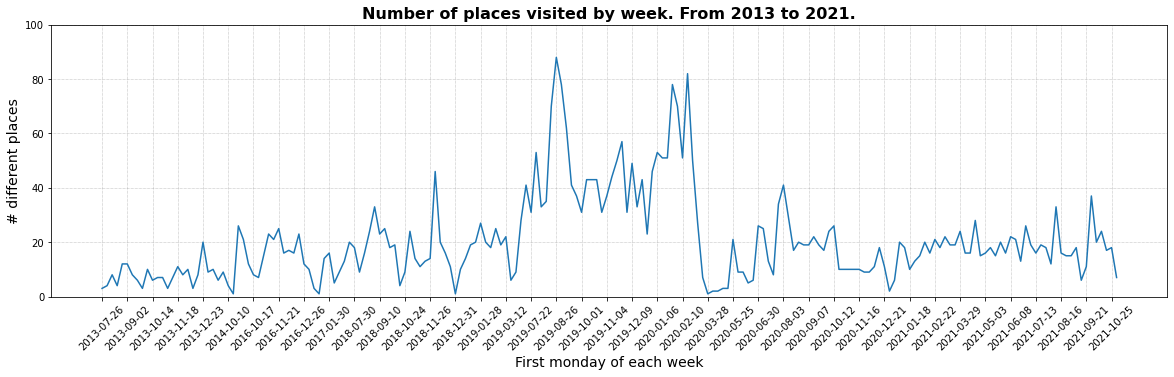

In [15]:
#We perform a quick plot to observe the behaviour of both meat consumption. 
fig, ax = plt.subplots(figsize=(20,5))
plt.xticks(rotation = 45, fontsize = 16)

#We define our values
x_values = count_places["date"].values
y_values = count_places["num_places"].values


plt.plot(x_values, y_values)
x_to_show = [x_values[step] for step in np.arange(0,len(x_values),5)]
plt.xticks(x_to_show);

plt.xlabel("First monday of each week", fontsize = 14)
plt.ylabel("# different places", fontsize = 14)

plt.ylim((0,100))
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')

plt.title("Number of places visited by week. From 2013 to 2021.", fontsize='16', fontweight='bold')
plt.xticks(rotation = 45, label=5, size=10);


In [16]:
pysqldf("""
SELECT SUM(num_places) AS num_places,
       year
       
FROM count_places
GROUP BY 2
""")

num_places  year
0         160  2013
1          39  2014
2         242  2016
3          49  2017
4         410  2018
5        1364  2019
6        1096  2020
7         804  2021

In [17]:
jeje  = np.datetime64(visited_places["startTimestamp"].values[0])
year  = jeje.astype('datetime64[Y]').astype(int) + 1970
month = jeje.astype('datetime64[M]').astype(int) % 12 + 1
month = jeje.astype('datetime64[M]').astype(int) % 12 + 1

# To extract the day:
day = (jeje.astype('datetime64[D]').astype(int) % 365) % 31 + 1
print(f"Day: {day}")

# Print the complete date:
date = jeje.astype('datetime64[D]')
print(date)

Day: 7
2013-09-01


/var/folders/5h/h364vcws335c872gj8pv3jvm0000gn/T/ipykernel_31264/584758323.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  jeje  = np.datetime64(visited_places["startTimestamp"].values[0])


In [18]:
gdf = gpd.GeoDataFrame(visited_places, geometry=gpd.points_from_xy(visited_places["longitude"], visited_places["latitude"]),crs="EPSG:4326")
gdf = gdf[['latitude', 'longitude', 'loc_confindence', 'placeConfidence', 'loc_name', 'place_id',
       'loc_address', 'source_file', 
       'duration', 'geometry']]


In [19]:
gdf.columns

Index(['latitude', 'longitude', 'loc_confindence', 'placeConfidence',
       'loc_name', 'place_id', 'loc_address', 'source_file', 'duration',
       'geometry'],
      dtype='object')

In [20]:
gdf.explore()

In [21]:
gdf

latitude  longitude  loc_confindence    placeConfidence  \
1     42.233010   2.632356        38.099730     LOW_CONFIDENCE   
2     42.232817   2.629671        40.062973  MEDIUM_CONFIDENCE   
3     42.233010   2.632356        47.195095  MEDIUM_CONFIDENCE   
4     42.233883   2.631954        18.509200     LOW_CONFIDENCE   
5     42.232817   2.629671        46.037770     LOW_CONFIDENCE   
...         ...        ...              ...                ...   
6430  41.194867   1.637823        27.902746  MEDIUM_CONFIDENCE   
6431  41.199889   1.643278        70.955000     LOW_CONFIDENCE   
6433  41.387015   2.170047        99.275566    HIGH_CONFIDENCE   
6434  41.387015   2.170047        99.938770    HIGH_CONFIDENCE   
6435  41.385446   2.163762        65.165726     LOW_CONFIDENCE   

                    loc_name                     place_id  \
1        Hotel Alta Garrotxa  ChIJXZSptju4uhIR9DOtWjX9H7U   
2     Ajuntament de Tortellà  ChIJVZBjJDu4uhIRVkeIG1VR7qQ   
3        Hotel Alta Garrotxa  ChIJXZSptju4uhIR9DOtWjX9H7U   
4      Juan Verges Verdaguer  ChIJST8x4Dq4uhIRjE17wBS4a1s   
5     Ajuntament de Tortellà  ChIJVZBjJDu4uhIRVkeIG1VR7qQ   
...                      ...                          ...   
6430    Camping Mar De Cunit  ChIJJfAwGNaIoxIRMnVQHWE4wNU   
6431        Camping la Rueda  ChIJkUoGtdqHoxIRBxACCwEdJfo   
6433      Plaça de Catalunya  ChIJGUgrYPGipBIRS9ZgHK_C7B4   
6434      Plaça de Catalunya  ChIJGUgrYPGipBIRS9ZgHK_C7B4   
6435             Universitat  ChIJg3GdR4uipBIRrGWfaj6Y_s4   

                                            loc_address          source_file  \
1     Carrer Sant Joan, 12, 17853 Tortellà, Girona, ...  2013_SEPTEMBER.json   
2      Plaça Mercat, 21, 17853 Tortellà, Girona, España  2013_SEPTEMBER.json   
3     Carrer Sant Joan, 12, 17853 Tortellà, Girona, ...  2013_SEPTEMBER.json   
4     Carrer de França, 1, 17853 Tortellà, Girona, E...  2013_SEPTEMBER.json   
5      Plaça Mercat, 21, 17853 Tortellà, Girona, España  2013_SEPTEMBER.json   
...                                                 ...                  ...   
6430  Avinguda de Tarragona, 146, 43881 Cunit, Tarra...     2016_AUGUST.json   
6431  Carretera C-31, Km. 146,2, 08880 Cubelles, Bar...     2016_AUGUST.json   
6433       Plaça de Catalunya, 08002 Barcelona, Espanya     2016_AUGUST.json   
6434       Plaça de Catalunya, 08002 Barcelona, Espanya     2016_AUGUST.json   
6435                            08007 Barcelona, España     2016_AUGUST.json   

        duration                  geometry  
1      27.189233  POINT (2.63236 42.23301)  
2      95.311667  POINT (2.62967 42.23282)  
3     226.672100  POINT (2.63236 42.23301)  
4      54.058367  POINT (2.63195 42.23388)  
5      39.111217  POINT (2.62967 42.23282)  
...          ...                       ...  
6430  165.330933  POINT (1.63782 41.19487)  
6431    5.833333  POINT (1.64328 41.19989)  
6433    6.532883  POINT (2.17005 41.38702)  
6434  124.871517  POINT (2.17005 41.38702)  
6435    6.270517  POINT (2.16376 41.38545)  

[4164 rows x 10 columns]